In [50]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from tensorflow import keras

In [51]:
mlb_data = pandas.read_csv("FATHIA DATASET NEW 6.1.csv")
mlb_data.head()

,ComplexProject,ProjectwithRisk,AssociatedCost,ProjectDuration,CustomerInvolvement,ImplementationStage,RequirementGathering,Maintainability,ErrorDiscovery,Flexibility,MODEL
0,4,1,3,5,1,1,5,5,1,1,WATERFALL
1,5,4,4,5,3,4,5,4,4,5,WATERFALL
2,3,3,3,3,3,3,3,3,3,3,WATERFALL
3,4,4,3,4,5,3,3,5,5,3,WATERFALL
4,5,1,3,3,1,1,5,1,1,1,WATERFALL


In [52]:
mlb_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8520 entries, 0 to 8519
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ComplexProject        8520 non-null   int64 
 1   ProjectwithRisk       8520 non-null   int64 
 2   AssociatedCost        8520 non-null   int64 
 3   ProjectDuration       8520 non-null   int64 
 4   CustomerInvolvement   8520 non-null   int64 
 5   ImplementationStage   8520 non-null   int64 
 6   RequirementGathering  8520 non-null   int64 
 7   Maintainability       8520 non-null   int64 
 8   ErrorDiscovery        8520 non-null   int64 
 9   Flexibility           8520 non-null   int64 
 10  MODEL                 8520 non-null   object
dtypes: int64(10), object(1)
memory usage: 732.3+ KB


In [53]:
#mlb_data = mlb_data.drop(['TOTAL','CLASSIFICATION','SUBCLASSIFICATION','SUBCLASSIFICATION2'], axis=1)

In [54]:
num_features = ['ComplexProject', 'ProjectwithRisk ', 'AssociatedCost',
       'ProjectDuration', 'CustomerInvolvement', 'ImplementationStage',
       'RequirementGathering', 'Maintainability ', 'ErrorDiscovery ',
       'Flexibility']
X = mlb_data[num_features]

# Normalize data using StandardScaler
scaler = MinMaxScaler()
col = X.columns
X_normalized = scaler.fit_transform(X)


scalar_df = pandas.DataFrame(X_normalized, columns=col)

# Print normalized data
print(scalar_df)

      ComplexProject  ProjectwithRisk   AssociatedCost  ProjectDuration  \
0               0.75          0.000000            0.50             1.00   
1               1.00          1.000000            0.75             1.00   
2               0.50          0.666667            0.50             0.50   
3               0.75          1.000000            0.50             0.75   
4               1.00          0.000000            0.50             0.50   
...              ...               ...             ...              ...   
8515            0.00          0.000000            0.50             0.50   
8516            0.00          0.000000            0.75             0.75   
8517            0.00          0.000000            0.50             0.50   
8518            0.00          0.333333            0.50             1.00   
8519            0.00          0.000000            0.50             0.50   

      CustomerInvolvement  ImplementationStage  RequirementGathering  \
0                     0.0  

In [55]:
# Convert dataframe to NumPy arrays
X = scalar_df.values
Y = mlb_data.iloc[:, -1].values

In [56]:
# Encode the target variable to numerical labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

In [57]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

In [58]:
# Normalize the input features
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [59]:
# Convert target variable to one-hot encoded format
Y_train_encoded = keras.utils.to_categorical(Y_train)
Y_test_encoded = keras.utils.to_categorical(Y_test)

In [60]:
X_train = np.reshape(X_train,((len(X_train),10,1)))
X_test= np.reshape(X_test,(len(X_test),10,1))

In [61]:
model = keras.models.Sequential()
#model.add(keras.layers.Embedding(10000, 128))
model.add(keras.layers.SimpleRNN(64, return_sequences=True,input_shape=(10, 1)))
model.add(keras.layers.SimpleRNN(64))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(len(label_encoder.classes_), activation="softmax"))
  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10, 64)            4224      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                1935      
Total params: 22,735
Trainable params: 22,735
Non-trainable params: 0
_________________________________________________________________


In [62]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [63]:
checkpoint_filepath = '/content/drive/MyDrive/jet data/models/cnn'

In [64]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [65]:
batch_size=32

In [66]:
# Train the model
history = model.fit(X_train, Y_train_encoded, batch_size = batch_size, epochs = 100, 
                   steps_per_epoch = len(X_train) // batch_size,
                   validation_steps = len(X_test) // batch_size, 
                   validation_data = (X_test, Y_test_encoded),
                   callbacks = [model_checkpoint_callback])

Epoch 1/100
213/213 [==============================] - 23s 106ms/step - loss: 1.6795 - accuracy: 0.4602 - precision_1: 0.7678 - recall_1: 0.2450 - root_mean_squared_error: 0.2104 - mean_squared_error: 0.0443 - mean_absolute_error: 0.0915 - val_loss: 1.3514 - val_accuracy: 0.5601 - val_precision_1: 0.8769 - val_recall_1: 0.4074 - val_root_mean_squared_error: 0.1886 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.0751
Epoch 2/100
213/213 [==============================] - 18s 84ms/step - loss: 1.3617 - accuracy: 0.5417 - precision_1: 0.7779 - recall_1: 0.3922 - root_mean_squared_error: 0.1934 - mean_squared_error: 0.0374 - mean_absolute_error: 0.0759 - val_loss: 1.2680 - val_accuracy: 0.5625 - val_precision_1: 0.8383 - val_recall_1: 0.4340 - val_root_mean_squared_error: 0.1859 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.0711
Epoch 3/100
213/213 [==============================] - 17s 80ms/step - loss: 1.2761 - accuracy: 0.5651 - precision_1: 0.7979 - recall

213/213 [==============================] - 22s 105ms/step - loss: 0.8596 - accuracy: 0.6703 - precision_1: 0.8427 - recall_1: 0.5290 - root_mean_squared_error: 0.1661 - mean_squared_error: 0.0276 - mean_absolute_error: 0.0569 - val_loss: 0.8333 - val_accuracy: 0.6763 - val_precision_1: 0.8852 - val_recall_1: 0.5094 - val_root_mean_squared_error: 0.1626 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.0552
Epoch 13/100
213/213 [==============================] - 2s 9ms/step - loss: 0.8298 - accuracy: 0.6831 - precision_1: 0.8495 - recall_1: 0.5401 - root_mean_squared_error: 0.1642 - mean_squared_error: 0.0270 - mean_absolute_error: 0.0558 - val_loss: 0.8428 - val_accuracy: 0.6757 - val_precision_1: 0.8741 - val_recall_1: 0.5242 - val_root_mean_squared_error: 0.1639 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.0559
Epoch 14/100
213/213 [==============================] - 21s 98ms/step - loss: 0.7897 - accuracy: 0.6969 - precision_1: 0.8520 - recall_1: 0.5515 -

Epoch 24/100
213/213 [==============================] - 18s 84ms/step - loss: 0.5315 - accuracy: 0.7757 - precision_1: 0.8721 - recall_1: 0.6840 - root_mean_squared_error: 0.1382 - mean_squared_error: 0.0191 - mean_absolute_error: 0.0406 - val_loss: 0.4771 - val_accuracy: 0.8084 - val_precision_1: 0.8939 - val_recall_1: 0.7152 - val_root_mean_squared_error: 0.1311 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0375
Epoch 25/100
213/213 [==============================] - 2s 9ms/step - loss: 0.4939 - accuracy: 0.7965 - precision_1: 0.8829 - recall_1: 0.7091 - root_mean_squared_error: 0.1336 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0385 - val_loss: 0.4606 - val_accuracy: 0.8060 - val_precision_1: 0.8867 - val_recall_1: 0.7288 - val_root_mean_squared_error: 0.1295 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0356
Epoch 26/100
213/213 [==============================] - 2s 9ms/step - loss: 0.4984 - accuracy: 0.7895 - precision_1: 0.8751 - recall_1

213/213 [==============================] - 18s 82ms/step - loss: 0.3741 - accuracy: 0.8310 - precision_1: 0.8943 - recall_1: 0.7780 - root_mean_squared_error: 0.1194 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0300 - val_loss: 0.3196 - val_accuracy: 0.8550 - val_precision_1: 0.9089 - val_recall_1: 0.8172 - val_root_mean_squared_error: 0.1109 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0255
Epoch 39/100
213/213 [==============================] - 2s 9ms/step - loss: 0.3751 - accuracy: 0.8335 - precision_1: 0.8939 - recall_1: 0.7799 - root_mean_squared_error: 0.1191 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0298 - val_loss: 0.3405 - val_accuracy: 0.8302 - val_precision_1: 0.8879 - val_recall_1: 0.7942 - val_root_mean_squared_error: 0.1153 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0271
Epoch 40/100
213/213 [==============================] - 2s 9ms/step - loss: 0.3765 - accuracy: 0.8308 - precision_1: 0.8942 - recall_1: 0.7839 - ro

Epoch 55/100
213/213 [==============================] - 2s 9ms/step - loss: 0.3422 - accuracy: 0.8367 - precision_1: 0.8958 - recall_1: 0.7949 - root_mean_squared_error: 0.1148 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0271 - val_loss: 0.2878 - val_accuracy: 0.8526 - val_precision_1: 0.9025 - val_recall_1: 0.8190 - val_root_mean_squared_error: 0.1071 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0230
Epoch 56/100
213/213 [==============================] - 2s 9ms/step - loss: 0.3191 - accuracy: 0.8473 - precision_1: 0.9054 - recall_1: 0.8074 - root_mean_squared_error: 0.1114 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0255 - val_loss: 0.2695 - val_accuracy: 0.8579 - val_precision_1: 0.9075 - val_recall_1: 0.8331 - val_root_mean_squared_error: 0.1035 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0212
Epoch 57/100
213/213 [==============================] - 2s 9ms/step - loss: 0.3200 - accuracy: 0.8504 - precision_1: 0.9049 - recall_1: 

213/213 [==============================] - 2s 9ms/step - loss: 0.2943 - accuracy: 0.8493 - precision_1: 0.9057 - recall_1: 0.8132 - root_mean_squared_error: 0.1083 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0237 - val_loss: 0.2420 - val_accuracy: 0.8656 - val_precision_1: 0.9137 - val_recall_1: 0.8432 - val_root_mean_squared_error: 0.0996 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0192
Epoch 74/100
213/213 [==============================] - 2s 9ms/step - loss: 0.3023 - accuracy: 0.8518 - precision_1: 0.9088 - recall_1: 0.8159 - root_mean_squared_error: 0.1085 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0238 - val_loss: 0.2980 - val_accuracy: 0.8555 - val_precision_1: 0.9025 - val_recall_1: 0.8243 - val_root_mean_squared_error: 0.1079 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0234
Epoch 75/100
213/213 [==============================] - 2s 9ms/step - loss: 0.3394 - accuracy: 0.8379 - precision_1: 0.8972 - recall_1: 0.7993 - root

Epoch 91/100
213/213 [==============================] - 2s 10ms/step - loss: 0.3770 - accuracy: 0.8305 - precision_1: 0.8880 - recall_1: 0.7918 - root_mean_squared_error: 0.1187 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0272 - val_loss: 0.2839 - val_accuracy: 0.8526 - val_precision_1: 0.9072 - val_recall_1: 0.8184 - val_root_mean_squared_error: 0.1068 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0223
Epoch 92/100
213/213 [==============================] - 2s 9ms/step - loss: 0.3029 - accuracy: 0.8496 - precision_1: 0.9034 - recall_1: 0.8106 - root_mean_squared_error: 0.1098 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0242 - val_loss: 0.2486 - val_accuracy: 0.8644 - val_precision_1: 0.9076 - val_recall_1: 0.8396 - val_root_mean_squared_error: 0.1008 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0194
Epoch 93/100
213/213 [==============================] - 2s 9ms/step - loss: 0.2727 - accuracy: 0.8614 - precision_1: 0.9167 - recall_1:

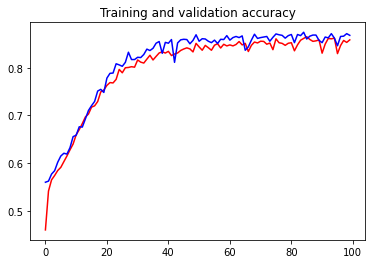

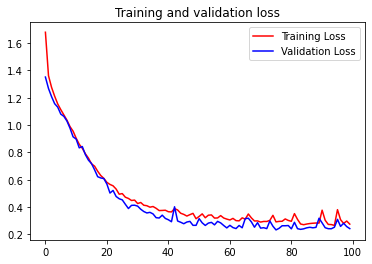

In [67]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [68]:
# Evaluate the model on the test set


In [69]:
print('The Training metrics are:')
model.evaluate(X_train, Y_train_encoded)

The Training metrics are:
213/213 [==============================] - 1s 6ms/step - loss: 0.2281 - accuracy: 0.8750 - precision_1: 0.9330 - recall_1: 0.8360 - root_mean_squared_error: 0.0972 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0190


[0.22814276814460754,
 0.875,
 0.9330276846885681,
 0.8359741568565369,
 0.09720294922590256,
 0.00944841280579567,
 0.018985074013471603]

In [70]:
print('The validation metrics are:')
model.evaluate(X_test, Y_test_encoded)

The validation metrics are:
54/54 [==============================] - 0s 4ms/step - loss: 0.2465 - accuracy: 0.8680 - precision_1: 0.9187 - recall_1: 0.8427 - root_mean_squared_error: 0.0983 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0182


[0.24647608399391174,
 0.8679577708244324,
 0.9187459945678711,
 0.84272301197052,
 0.0983191505074501,
 0.009666652418673038,
 0.018176481127738953]

In [74]:
prediction = model.predict( X_test)
print(prediction)

[[2.01714579e-02 2.56545445e-05 2.98756375e-09 ... 2.35282513e-08
  7.31987658e-13 4.85808778e-06]
 [6.99902469e-10 2.02491925e-08 1.21951498e-05 ... 2.96781016e-10
  6.66967244e-05 1.15724094e-06]
 [9.70948349e-06 2.14095600e-03 3.95552925e-04 ... 3.37469915e-04
  4.42294912e-09 1.29111531e-05]
 ...
 [2.54267361e-05 2.39965070e-09 2.84574057e-12 ... 6.08431654e-13
  3.47178926e-16 5.16822782e-12]
 [2.67286756e-17 6.60506719e-11 8.15235466e-12 ... 7.23776683e-09
  3.27488687e-12 5.88454654e-08]
 [2.13572285e-10 1.13677561e-06 2.45851295e-09 ... 2.42859579e-13
  1.73085712e-11 1.25405375e-08]]


In [80]:
rnn_error = np.subtract(Y_test_encoded, prediction)
df = pandas.DataFrame(list(zip(Y_test_encoded, prediction, rnn_error)), 
    columns=['Actual Value', 'RNN Prediction', 'RNN Error'])
#df.to_excel("result for cnn 80_20.xlsx")
df

,Actual Value,RNN Prediction,RNN Error
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.020171458, 2.5654545e-05, 2.9875638e-09, 0....","[-0.020171458, -2.5654545e-05, -2.9875638e-09,..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[6.9990247e-10, 2.0249193e-08, 1.219515e-05, 7...","[-6.9990247e-10, -2.0249193e-08, -1.219515e-05..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[9.7094835e-06, 0.002140956, 0.00039555292, 5....","[-9.7094835e-06, -0.002140956, -0.00039555292,..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[5.6771455e-06, 1.5121413e-08, 3.5030532e-13, ...","[-5.6771455e-06, -1.5121413e-08, -3.5030532e-1..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1.3432958e-09, 3.4538112e-11, 1.3516429e-06, ...","[-1.3432958e-09, -3.4538112e-11, -1.3516429e-0..."
...,...,...,...
1699,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0010450258, 1.2244598e-06, 1.7329284e-06, 8...","[-0.0010450258, -1.2244598e-06, -1.7329284e-06..."
1700,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.2859485e-14, 6.056705e-10, 1.1699175e-06, 0...","[-1.2859485e-14, -6.056705e-10, -1.1699175e-06..."
1701,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[2.5426736e-05, 2.3996507e-09, 2.8457406e-12, ...","[-2.5426736e-05, -2.3996507e-09, -2.8457406e-1..."
1702,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.6728676e-17, 6.605067e-11, 8.152355e-12, 0....","[-2.6728676e-17, -6.605067e-11, -8.152355e-12,..."


In [81]:
# Save the model as a pickle in a file


In [82]:
model.save("C:/Users/NCC/Documents/SOFTWAREML/model/dumped.keras")

OSError: Unable to create file (unable to open file: name = 'C:/Users/NCC/Documents/SOFTWAREML/model/dumped.keras', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [49]:
keras.models.load_model("C:/Users/NCC/Documents/SOFTWAREML/model/dumped.keras")